In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/becauseofliver/sample_submission.csv
/kaggle/input/becauseofliver/train.csv
/kaggle/input/becauseofliver/test.csv


In [2]:
# 라이브러리 임포트
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# 데이터 로드
train = pd.read_csv('/kaggle/input/becauseofliver/train.csv')
test = pd.read_csv('/kaggle/input/becauseofliver/test.csv')

# 피처와 라벨 분리 (id 컬럼 및 Sex 제거)
X = train.drop(['Status', 'id', 'Sex'], axis=1)
y = train['Status']

# 범주형 피처 정의
categorical_features = ['Drug', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']

# 수치형 피처 정의
numerical_features = [col for col in X.columns if col not in categorical_features]

# 데이터 분할 (학습 70%, 테스트 30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

# OneHotEncoder 학습 데이터에 피팅
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoder.fit(X_train[categorical_features])

# 학습 데이터 인코딩
encoded_train = pd.DataFrame(encoder.transform(X_train[categorical_features]), columns=encoder.get_feature_names_out(categorical_features))
X_train_num = X_train[numerical_features].reset_index(drop=True)
X_train_encoded = pd.concat([X_train_num, encoded_train.reset_index(drop=True)], axis=1)

# 테스트 데이터 인코딩
encoded_test = pd.DataFrame(encoder.transform(X_test[categorical_features]), columns=encoder.get_feature_names_out(categorical_features))
X_test_num = X_test[numerical_features].reset_index(drop=True)
X_test_encoded = pd.concat([X_test_num, encoded_test.reset_index(drop=True)], axis=1)

# 제출용 테스트 데이터에서 Sex 제거
test_features = test.drop(['id', 'Sex'], axis=1)
encoded_test_submission = pd.DataFrame(encoder.transform(test_features[categorical_features]), columns=encoder.get_feature_names_out(categorical_features))
test_num = test_features[numerical_features].reset_index(drop=True)
test_features_encoded = pd.concat([test_num, encoded_test_submission.reset_index(drop=True)], axis=1)

# 스케일러 선택 및 학습 데이터에 피팅
scaler = StandardScaler()
scaler.fit(X_train_encoded[numerical_features])

# 학습 데이터 스케일링
X_train_scaled = X_train_encoded.copy()
X_train_scaled[numerical_features] = scaler.transform(X_train_encoded[numerical_features])

# 테스트 데이터 스케일링
X_test_scaled = X_test_encoded.copy()
X_test_scaled[numerical_features] = scaler.transform(X_test_encoded[numerical_features])

# 제출용 데이터 스케일링
test_features_scaled = test_features_encoded.copy()
test_features_scaled[numerical_features] = scaler.transform(test_features_encoded[numerical_features])

Test Accuracy: 90.00%


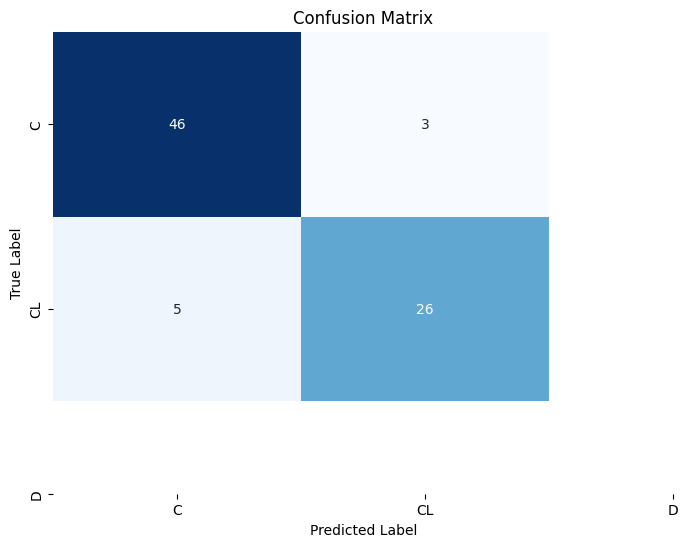

Baseline submission file created: submission.csv


,id,LiverStatus_C,LiverStatus_CL,LiverStatus_D
0,7905,0.534737,0.094312,0.370951
1,7906,0.609970,0.180141,0.209889
2,7907,0.042414,0.023669,0.933917
3,7908,0.959256,0.003268,0.037476
4,7909,0.795277,0.052153,0.152570


In [3]:
# 모델 학습
model = GradientBoostingClassifier(
    n_estimators=200,       # 트리의 개수
    learning_rate=0.05,     # 학습률
    max_depth=4,            # 트리의 최대 깊이
    min_samples_split=3,    # 노드 분할을 위한 최소 샘플 수
    min_samples_leaf=2,     # 리프 노드의 최소 샘플 수
    subsample=0.8,          # 각 단계에서 사용할 샘플 비율
    random_state=42         # 랜덤 시드
)
model.fit(X_train_scaled, y_train)

# 테스트 세트로 모델 평가
y_pred_test = model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 제출용 예측 생성
final_predictions_proba = model.predict_proba(test_features_scaled)

# 예측 결과를 DataFrame으로 변환
submission = pd.DataFrame(final_predictions_proba, columns=[f'LiverStatus_{cls}' for cls in model.classes_])

# 'id' 컬럼 추가
submission['id'] = test['id']

# 컬럼 순서 재정렬
submission = submission[['id'] + [col for col in submission.columns if col != 'id']]

# 제출 파일 저장
submission.to_csv('submission.csv', index=False)

print('Baseline submission file created: submission.csv')
submission.head()